# 01 — Data Exploration, Target Definition & Governance

This notebook establishes the analytical and governance foundations for an
**early credit risk warning analysis** using the German Credit dataset.

The purpose of this notebook is to define the **problem framing**, validate the
raw data, and perform a **minimal, risk-informed exploratory analysis** before
any preprocessing or modeling decisions are made.

No preprocessing, feature engineering, or modeling is performed here.

---

## Objectives

- Define the early credit risk event (`y_bad`) in a transparent and auditable way  
- Validate raw data structure, types, and completeness  
- Quantify class imbalance and event prevalence  
- Perform a focused exploratory analysis on key credit-relevant variables  
- Identify variables that may act as socio-economic or structural proxies  
- Establish governance constraints for downstream modeling  

---

## Real-World Usage Context

The analysis is framed as an **early warning system**, not a credit approval or
pricing mechanism.

Model outputs are intended to:
- support portfolio monitoring,
- flag accounts for manual review,
- inform early, proportionate interventions.

They are **not** intended to automate acceptance, rejection, or pricing decisions.

---

## Governance Principles

- **No target leakage**: outcome-derived or contemporaneous information is not
  introduced prior to modeling.
- **Clear separation of roles**: this notebook defines context and validates data;
  all transformations and modeling occur downstream.
- **Interpretability first**: baseline models will be favored before non-linear
  benchmarks.
- **Proxy awareness**: variables related to employment, housing, age, and personal
  status are treated as risk signals requiring contextual interpretation, not
  causal drivers.
- **Transparency**: all assumptions, mappings, and limitations are documented
  explicitly.

---

## Scope and Limitations

The German Credit dataset reflects historical credit practices and embedded
decision patterns that do not meet modern fairness or governance standards.

This project is intended to:
- demonstrate risk-aware modeling methodology,
- illustrate early warning framing,
- emphasize responsible use of predictive analytics.

It is **not intended for production deployment**.


#### Environment setup

In [10]:
# Objective:
# Ensure a clean, reproducible environment and load all dependencies required
# for data preparation, modeling, and diagnostics.

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report
)
from pathlib import Path

# Project paths
NOTEBOOK_DIR = Path("/Users/steph/Desktop/Github/early-warning-credit-risk/02_notebooks")
PROJECT_ROOT = NOTEBOOK_DIR.parent

RAW_DATA_DIR = PROJECT_ROOT / "01_dataset"
RAW_DATA_PATH = RAW_DATA_DIR / "german.data"

# Fail fast if raw data is missing
assert RAW_DATA_PATH.exists(), f"Raw data not found: {RAW_DATA_PATH}"

print("Loading raw data from:", RAW_DATA_PATH.resolve())


Loading raw data from: /Users/steph/Desktop/Github/early-warning-credit-risk/01_dataset/german.data


#### Loading dataset

In [11]:
# Data Loading – Governance Notes
#
# - Data is loaded from a local static file to ensure reproducibility.
# - Parsing parameters are specified explicitly to avoid implicit assumptions.
# - No transformations or preprocessing are applied at this stage.
# - Raw data ingestion is kept separate from downstream processing for traceability.
#

df = pd.read_csv(
    RAW_DATA_PATH,
    header=None,
    sep=r"\s+",
    engine="python"
)

print("Shape:", df.shape)
df.head()



Shape: (1000, 21)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


#### Column naming

In [12]:
# Objective:
# Assign meaningful variable names based on the official UCI documentation.
# This improves interpretability and auditability while preserving the original
# data structure (same row/column order, no transformation of values).
#

columns = [
    "status_checking_account",
    "duration_months",
    "credit_history",
    "purpose",
    "credit_amount",
    "savings_account",
    "employment_since",
    "installment_rate",
    "personal_status_sex",
    "other_debtors",
    "residence_since",
    "property",
    "age",
    "other_installment_plans",
    "housing",
    "existing_credits",
    "job",
    "num_dependents",
    "telephone",
    "foreign_worker",
    "credit_risk"
]

df.columns = columns


## Target definition (early credit risk event)

In the German Credit dataset, the target variable is encoded as:
- **1 = good credit**
- **2 = bad credit**

For early warning purposes, we define a binary event variable:
- `y_bad = 1` → bad credit (risk event)
- `y_bad = 0` → good credit

This framing makes the modeling objective explicit: predicting the **risk event**, not the favorable outcome.


In [13]:
# Inspect original target values
print("Original target values:", sorted(df["credit_risk"].unique()))

# Map to event label: 1 = bad (risk), 0 = good
df["y_bad"] = (df["credit_risk"] == 2).astype(int)

# Sanity check
print("\nEvent label (y_bad) distribution:")
print(df["y_bad"].value_counts().sort_index())


Original target values: [np.int64(1), np.int64(2)]

Event label (y_bad) distribution:
y_bad
0    700
1    300
Name: count, dtype: int64


## Class balance

Early credit risk and early warning problems are typically **imbalanced**:
the number of “bad” outcomes is much smaller than the number of “good” ones.

Understanding the class balance at this stage is critical because:
- accuracy can be misleading,
- later evaluation will focus on metrics aligned with early warning (recall, precision),
- threshold choices depend on event prevalence


In [14]:
# Class counts
class_counts = df["y_bad"].value_counts().sort_index()
print("Class counts (0 = good, 1 = bad):")
print(class_counts)

# Event rate
bad_rate = df["y_bad"].mean()
print(f"\nBad rate (event rate): {bad_rate:.4f} ({bad_rate*100:.2f}%)")


Class counts (0 = good, 1 = bad):
y_bad
0    700
1    300
Name: count, dtype: int64

Bad rate (event rate): 0.3000 (30.00%)


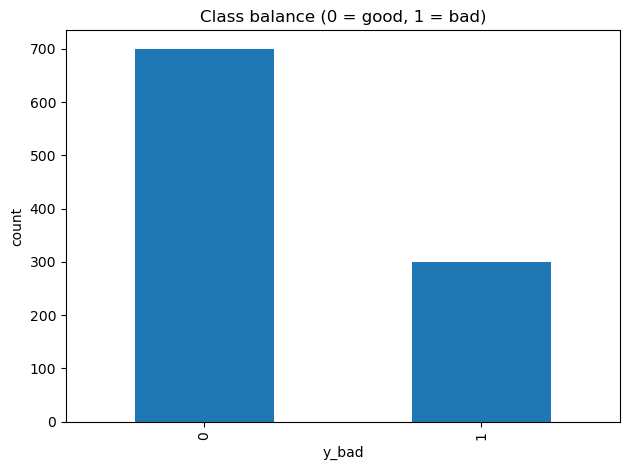

In [15]:
import matplotlib.pyplot as plt

plt.figure()
df["y_bad"].value_counts().sort_index().plot(kind="bar")
plt.title("Class balance (0 = good, 1 = bad)")
plt.xlabel("y_bad")
plt.ylabel("count")

plt.tight_layout()
plt.savefig("eda_class_balance.png", dpi=300, bbox_inches="tight")
plt.show()



**Interpretation:**  
The observed imbalance confirms that this is an early warning problem.
As a result, model evaluation in later notebooks will avoid accuracy-based metrics
and will prioritize recall and precision trade-offs.


#### Initial data inspection and sanity checks

In [16]:
# Sanity checks

df.info()
df["credit_risk"].value_counts()

# Count missing values per variable to identify patterns and severity
df.isna().sum()

# Detailed missingness report (explicit, auditable)
print("\nMissing values per column:")
display(df.isna().sum())

# Target distribution including potential missing values
print("\nTarget distribution (raw):")
display(df["credit_risk"].value_counts(dropna=False))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   status_checking_account  1000 non-null   object
 1   duration_months          1000 non-null   int64 
 2   credit_history           1000 non-null   object
 3   purpose                  1000 non-null   object
 4   credit_amount            1000 non-null   int64 
 5   savings_account          1000 non-null   object
 6   employment_since         1000 non-null   object
 7   installment_rate         1000 non-null   int64 
 8   personal_status_sex      1000 non-null   object
 9   other_debtors            1000 non-null   object
 10  residence_since          1000 non-null   int64 
 11  property                 1000 non-null   object
 12  age                      1000 non-null   int64 
 13  other_installment_plans  1000 non-null   object
 14  housing                  1000 non-null   

status_checking_account    0
duration_months            0
credit_history             0
purpose                    0
credit_amount              0
savings_account            0
employment_since           0
installment_rate           0
personal_status_sex        0
other_debtors              0
residence_since            0
property                   0
age                        0
other_installment_plans    0
housing                    0
existing_credits           0
job                        0
num_dependents             0
telephone                  0
foreign_worker             0
credit_risk                0
y_bad                      0
dtype: int64


Target distribution (raw):


credit_risk
1    700
2    300
Name: count, dtype: int64

## Minimal exploratory data analysis (EDA)

The goal of this EDA is not to exhaustively explore every variable,
but to understand whether **basic, well-known credit drivers**
show sensible relationships with early credit risk.

We focus on:
- a small number of numeric variables,
- a limited set of categorical variables,
- simple, interpretable comparisons between good and bad outcomes.


### Why these variables were selected

The variables examined in this exploratory analysis were chosen based on
**well-established credit risk principles**, not because they are expected
to be optimal predictors.

**Numeric variables**
- **Loan duration**: Longer repayment horizons are typically associated with
  higher uncertainty and greater exposure to adverse financial shocks.
- **Credit amount**: Larger loan sizes increase the financial burden on the
  borrower and may amplify repayment risk.
- **Age**: Age can proxy life-stage stability and income volatility, but must
  be interpreted cautiously due to fairness and governance considerations.

**Categorical variables**
- **Checking account status**: Liquidity indicators often provide early signals
  of financial stress.
- **Credit history**: Past repayment behavior is a strong indicator of future
  credit performance, though it reflects historical access to credit.
- **Purpose of the loan**: Different purposes carry different risk profiles
  (e.g., durable goods vs discretionary spending).
- **Savings account status**: Savings levels can act as a buffer against income
  shocks.
- **Employment status**: Employment stability is linked to income continuity,
  but may act as a socio-economic proxy.
- **Housing status**: Housing situation can reflect financial stability while
  also embedding structural and social factors.

These variables are included to:
- verify that the dataset exhibits **plausible credit-risk signal**,
- inform model design and interpretation,
- highlight areas where **governance and caution** are required.

They are not used to justify automated decision-making and are evaluated
strictly within a **decision-support** framework.


#### Numeric EDA 

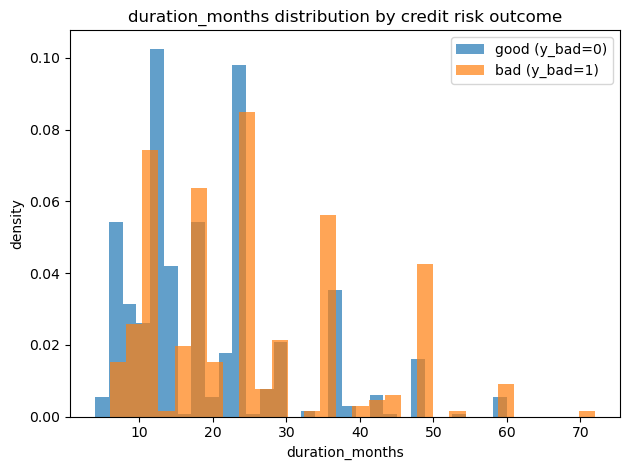

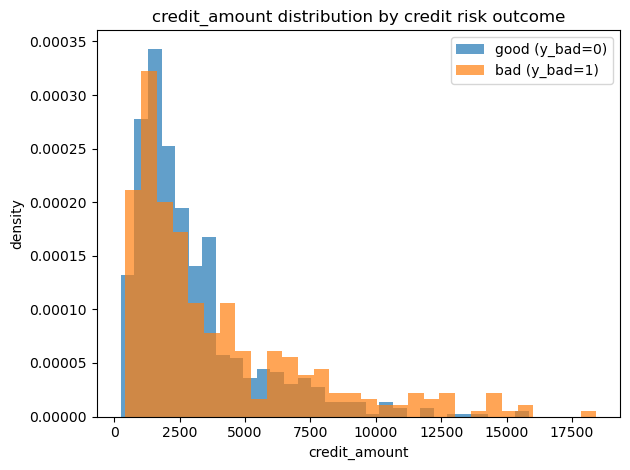

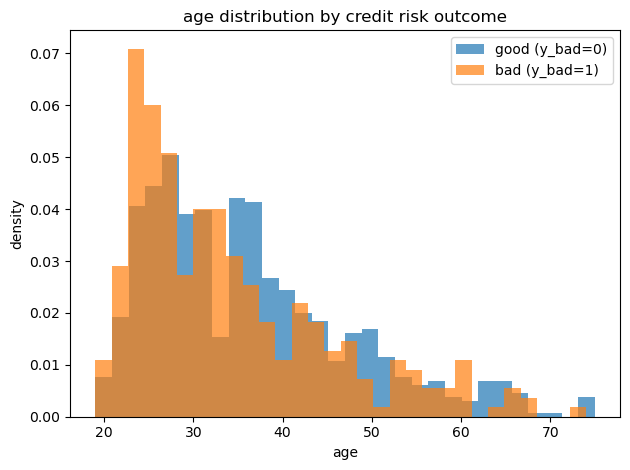

In [17]:
# Numeric EDA (aligned with actual column names)
numeric_vars = ["duration_months", "credit_amount", "age"]

for col in numeric_vars:
    plt.figure()
    df.loc[df["y_bad"] == 0, col].plot(kind="hist", bins=30, alpha=0.7, density=True)
    df.loc[df["y_bad"] == 1, col].plot(kind="hist", bins=30, alpha=0.7, density=True)

    plt.title(f"{col} distribution by credit risk outcome")
    plt.xlabel(col)
    plt.ylabel("density")
    plt.legend(["good (y_bad=0)", "bad (y_bad=1)"])

    plt.tight_layout()
    plt.savefig(f"eda_{col}_distribution.png", dpi=300, bbox_inches="tight")
    plt.show()


In [18]:
# Summary statistics by outcome
summary_numeric = (
    df.groupby("y_bad")[numeric_vars]
    .agg(["mean", "median"])
)

display(summary_numeric)


duration_months        credit_amount                age       
                 mean median          mean  median       mean median
y_bad                                                               
0           19.207143   18.0   2985.457143  2244.0  36.224286   34.0
1           24.860000   24.0   3938.126667  2574.5  33.963333   31.0

#### Categorical EDA

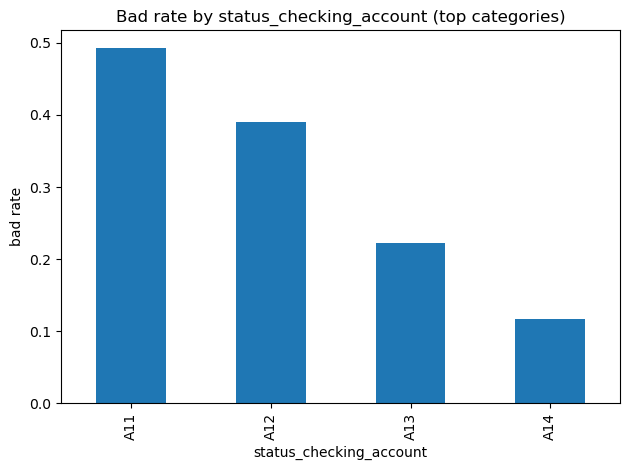

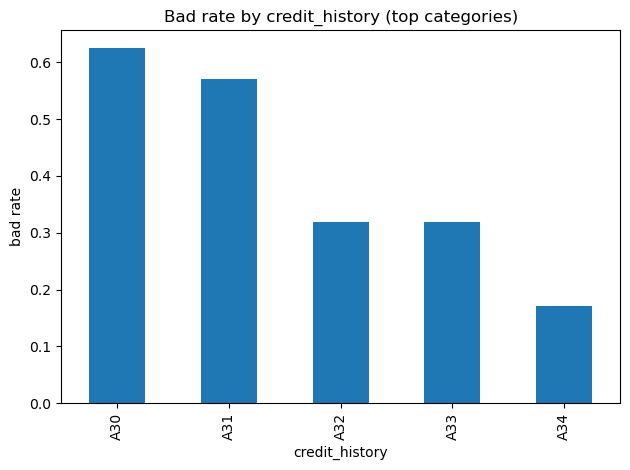

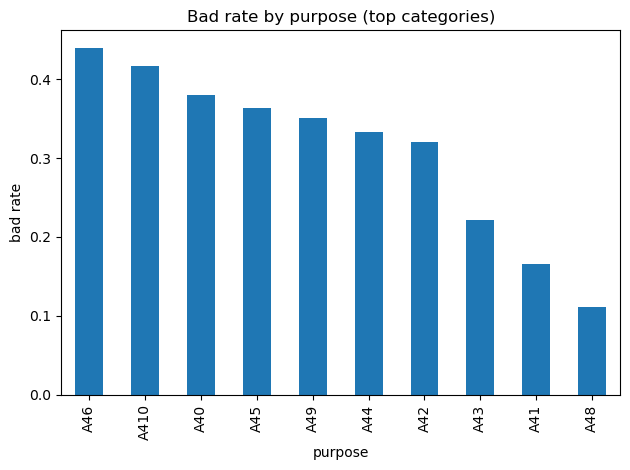

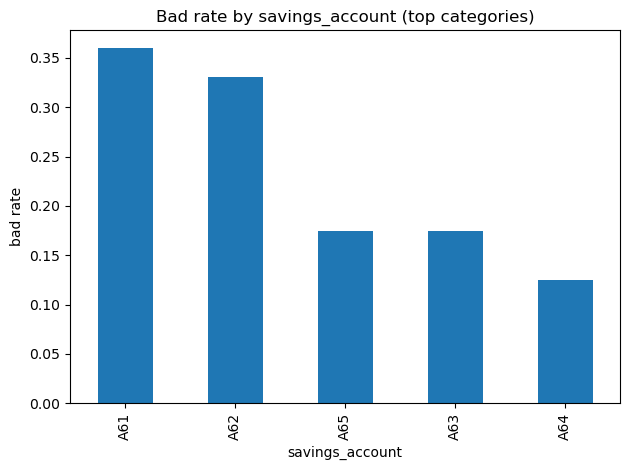

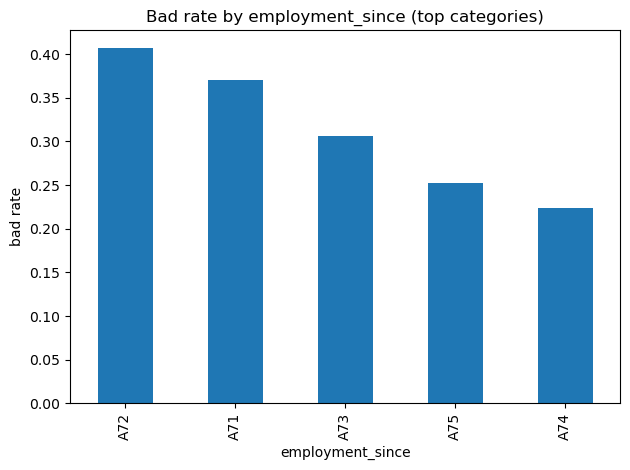

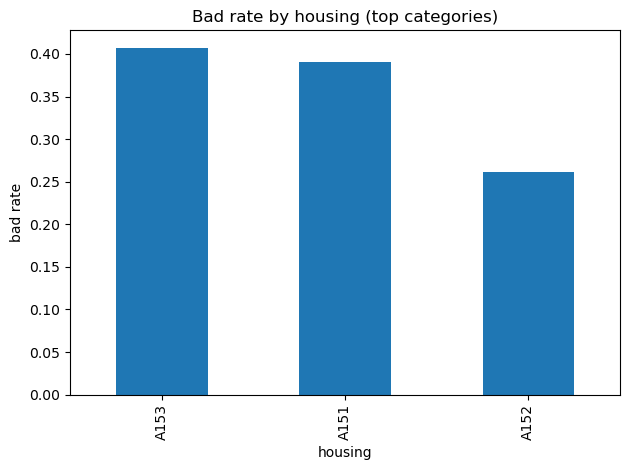

In [19]:
# Categorical EDA (aligned with actual column names)
categorical_vars = [
    "status_checking_account",
    "credit_history",
    "purpose",
    "savings_account",
    "employment_since",
    "housing",
]

for col in categorical_vars:
    bad_rate_by_cat = (
        df.groupby(col)["y_bad"]
        .mean()
        .sort_values(ascending=False)
        .head(15)
    )

    plt.figure()
    bad_rate_by_cat.plot(kind="bar")
    plt.title(f"Bad rate by {col} (top categories)")
    plt.xlabel(col)
    plt.ylabel("bad rate")

    plt.tight_layout()
    plt.savefig(f"eda_bad_rate_by_{col}.png", dpi=300, bbox_inches="tight")
    plt.show()



#### Saving files

In [20]:
from pathlib import Path
import json
from datetime import datetime
import pandas as pd

# Paths
NOTEBOOK_DIR = Path("/Users/steph/Desktop/Github/early-warning-credit-risk/02_notebooks")
PROJECT_ROOT = NOTEBOOK_DIR.parent

OUT_DIR = PROJECT_ROOT / "03_artifacts" / "notebook01"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Save dataset snapshot (with frozen target definition)
df_out = df.copy()
df_out.to_csv(OUT_DIR / "german_credit_with_y_bad.csv", index=False)

# Data dictionary
data_dictionary = pd.DataFrame({
    "column": df_out.columns,
    "dtype": [str(t) for t in df_out.dtypes]
})
data_dictionary.to_csv(OUT_DIR / "data_dictionary.csv", index=False)

# Missingness report
missingness_report = (
    df_out.isna().sum()
    .sort_values(ascending=False)
    .reset_index()
)
missingness_report.columns = ["column", "n_missing"]
missingness_report.to_csv(OUT_DIR / "missingness_report.csv", index=False)

# Run metadata (audit trail)
metadata = {
    "notebook": "01_setup_eda.ipynb",
    "timestamp": datetime.now().isoformat(),
    "source_file": "german.data",
    "n_rows": int(df_out.shape[0]),
    "n_columns": int(df_out.shape[1]),
    "raw_target_column": "credit_risk",
    "event_label_column": "y_bad",
    "event_definition": "1 = bad credit, 0 = good credit",
    "bad_rate": float(df_out["y_bad"].mean()),
    "notes": "EDA, target definition, class balance, and governance framing only. No preprocessing or modeling."
}

with open(OUT_DIR / "run_metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)


## Transition to Notebook 02

Notebook 02 will:
- construct train/test splits,
- build preprocessing pipelines,
- fit interpretable baseline models.

All inputs will be taken **unchanged** from the governed outputs of this notebook.
